In [1]:
# Imports
import torch
import torch.nn as nn  # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F  # All functions that don't have any parameters
import torchvision
import torchvision.datasets as datasets  # Has standard datasets we can import in a nice way
import torchvision.transforms as transforms  # Transformations we can perform on our dataset
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
from gtzan import GtzanData

lmao


In [3]:
GTZAN = GtzanData()

2


0it [00:00, ?it/s]

Tests created:  (2, 80, 911) (2,)
[[ 14.701719   18.728308   21.31778   ...   8.044062    8.945599
    7.3319674]
 [ 26.51512    27.860683   26.4856    ...   9.903543    9.261787
    8.540901 ]
 [ 26.158552   26.826677   27.35544   ...  15.468763   14.863864
   12.125663 ]
 ...
 [-11.586149  -12.982243  -18.877281  ... -13.463498  -11.278211
  -11.662217 ]
 [-12.157741  -13.903545  -18.416264  ... -20.792458  -16.125778
  -12.94232  ]
 [-12.430152  -17.555805  -26.156424  ... -28.839426  -28.053406
  -25.733494 ]]
Entering set_up_buckets loop
num of iterations: 18


18it [00:11,  1.61it/s]
0it [00:00, ?it/s]

18 [9, 4, 4, 0, 2, 3, 3, 6, 3, 5, 3, 6, 4, 7, 8, 2, 4, 2]
[[ 23.553425   19.43811     9.791897  ...  20.134354   20.524288
   20.966988 ]
 [ 19.030256   13.368706    5.1173563 ...  26.838795   26.904964
   25.67834  ]
 [ 24.162338   20.812328   12.804079  ...  24.319258   23.987755
   23.925186 ]
 ...
 [  4.7602596   4.3058414   2.9289908 ...  -7.2539663  -9.4389105
  -11.190515 ]
 [  3.0665028   3.230524    1.5103314 ... -12.056584  -13.434954
  -14.152022 ]
 [ -5.8101587  -5.267792   -7.1878963 ... -20.266045  -20.442991
  -20.45303  ]]
Entering init_dataframe loop
noise factor: 0.020000
noise factor: 0.040000
noise factor: 0.060000
noise factor: 0.080000
noise factor: 0.100000
pitch factor: -5.000000
pitch factor: -4.000000
pitch factor: -3.000000
pitch factor: -2.000000
pitch factor: -1.000000


1it [00:10, 10.51s/it]

noise factor: 0.020000
noise factor: 0.040000
noise factor: 0.060000
noise factor: 0.080000
noise factor: 0.100000
pitch factor: -5.000000
pitch factor: -4.000000
pitch factor: -3.000000
pitch factor: -2.000000
pitch factor: -1.000000


2it [00:20, 10.42s/it]

noise factor: 0.020000
noise factor: 0.040000
noise factor: 0.060000
noise factor: 0.080000
noise factor: 0.100000
pitch factor: -5.000000
pitch factor: -4.000000
pitch factor: -3.000000
pitch factor: -2.000000
pitch factor: -1.000000


3it [00:30, 10.31s/it]

noise factor: 0.020000
noise factor: 0.040000
noise factor: 0.060000
noise factor: 0.080000
noise factor: 0.100000
pitch factor: -5.000000
pitch factor: -4.000000
pitch factor: -3.000000
pitch factor: -2.000000
pitch factor: -1.000000


4it [00:40, 10.21s/it]

noise factor: 0.020000
noise factor: 0.040000
noise factor: 0.060000
noise factor: 0.080000
noise factor: 0.100000
pitch factor: -5.000000
pitch factor: -4.000000
pitch factor: -3.000000
pitch factor: -2.000000
pitch factor: -1.000000


5it [00:50, 10.11s/it]

noise factor: 0.020000
noise factor: 0.040000
noise factor: 0.060000
noise factor: 0.080000
noise factor: 0.100000
pitch factor: -5.000000
pitch factor: -4.000000
pitch factor: -3.000000
pitch factor: -2.000000
pitch factor: -1.000000


6it [01:00, 10.04s/it]

noise factor: 0.020000
noise factor: 0.040000
noise factor: 0.060000
noise factor: 0.080000
noise factor: 0.100000
pitch factor: -5.000000
pitch factor: -4.000000
pitch factor: -3.000000
pitch factor: -2.000000
pitch factor: -1.000000


7it [01:10, 10.01s/it]

noise factor: 0.020000
noise factor: 0.040000
noise factor: 0.060000
noise factor: 0.080000
noise factor: 0.100000
pitch factor: -5.000000
pitch factor: -4.000000
pitch factor: -3.000000
pitch factor: -2.000000
pitch factor: -1.000000


8it [01:20, 10.04s/it]

noise factor: 0.020000
noise factor: 0.040000
noise factor: 0.060000
noise factor: 0.080000
noise factor: 0.100000
pitch factor: -5.000000
pitch factor: -4.000000
pitch factor: -3.000000
pitch factor: -2.000000
pitch factor: -1.000000


9it [01:30,  9.96s/it]

noise factor: 0.020000
noise factor: 0.040000
noise factor: 0.060000
noise factor: 0.080000
noise factor: 0.100000
pitch factor: -5.000000
pitch factor: -4.000000
pitch factor: -3.000000
pitch factor: -2.000000
pitch factor: -1.000000


10it [01:40,  9.91s/it]

noise factor: 0.020000
noise factor: 0.040000
noise factor: 0.060000
noise factor: 0.080000
noise factor: 0.100000
pitch factor: -5.000000
pitch factor: -4.000000
pitch factor: -3.000000
pitch factor: -2.000000
pitch factor: -1.000000


11it [01:49,  9.87s/it]

noise factor: 0.020000
noise factor: 0.040000
noise factor: 0.060000
noise factor: 0.080000
noise factor: 0.100000
pitch factor: -5.000000
pitch factor: -4.000000
pitch factor: -3.000000
pitch factor: -2.000000
pitch factor: -1.000000


12it [01:59,  9.86s/it]

noise factor: 0.020000
noise factor: 0.040000
noise factor: 0.060000
noise factor: 0.080000
noise factor: 0.100000
pitch factor: -5.000000
pitch factor: -4.000000
pitch factor: -3.000000
pitch factor: -2.000000
pitch factor: -1.000000


13it [02:09,  9.84s/it]

noise factor: 0.020000
noise factor: 0.040000
noise factor: 0.060000
noise factor: 0.080000
noise factor: 0.100000
pitch factor: -5.000000
pitch factor: -4.000000
pitch factor: -3.000000
pitch factor: -2.000000
pitch factor: -1.000000


14it [02:19,  9.82s/it]

noise factor: 0.020000
noise factor: 0.040000
noise factor: 0.060000
noise factor: 0.080000
noise factor: 0.100000
pitch factor: -5.000000
pitch factor: -4.000000
pitch factor: -3.000000
pitch factor: -2.000000
pitch factor: -1.000000


15it [02:29,  9.81s/it]

noise factor: 0.020000
noise factor: 0.040000
noise factor: 0.060000
noise factor: 0.080000
noise factor: 0.100000
pitch factor: -5.000000
pitch factor: -4.000000
pitch factor: -3.000000
pitch factor: -2.000000
pitch factor: -1.000000


16it [02:38,  9.83s/it]

noise factor: 0.020000
noise factor: 0.040000
noise factor: 0.060000
noise factor: 0.080000
noise factor: 0.100000
pitch factor: -5.000000
pitch factor: -4.000000
pitch factor: -3.000000
pitch factor: -2.000000
pitch factor: -1.000000


17it [02:49,  9.89s/it]

noise factor: 0.020000
noise factor: 0.040000
noise factor: 0.060000
noise factor: 0.080000
noise factor: 0.100000
pitch factor: -5.000000
pitch factor: -4.000000
pitch factor: -3.000000
pitch factor: -2.000000
pitch factor: -1.000000


18it [02:58,  9.93s/it]

(198, 80, 911) (198,)


In [4]:
GTZAN.train_y

array([9, 4, 4, 0, 2, 3, 3, 6, 3, 5, 3, 6, 4, 7, 8, 2, 4, 2, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [5]:
from gtzan import GtzanDataset

transform = transforms.Compose(
    [
        transforms.ToTensor()
    ]
)
train_dataset = GtzanDataset(GTZAN.train_x, GTZAN.train_y, transform=transform)
test_dataset = GtzanDataset(GTZAN.test_x, GTZAN.test_y, transform=transform)

In [7]:
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset=train_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels: tensor([9])


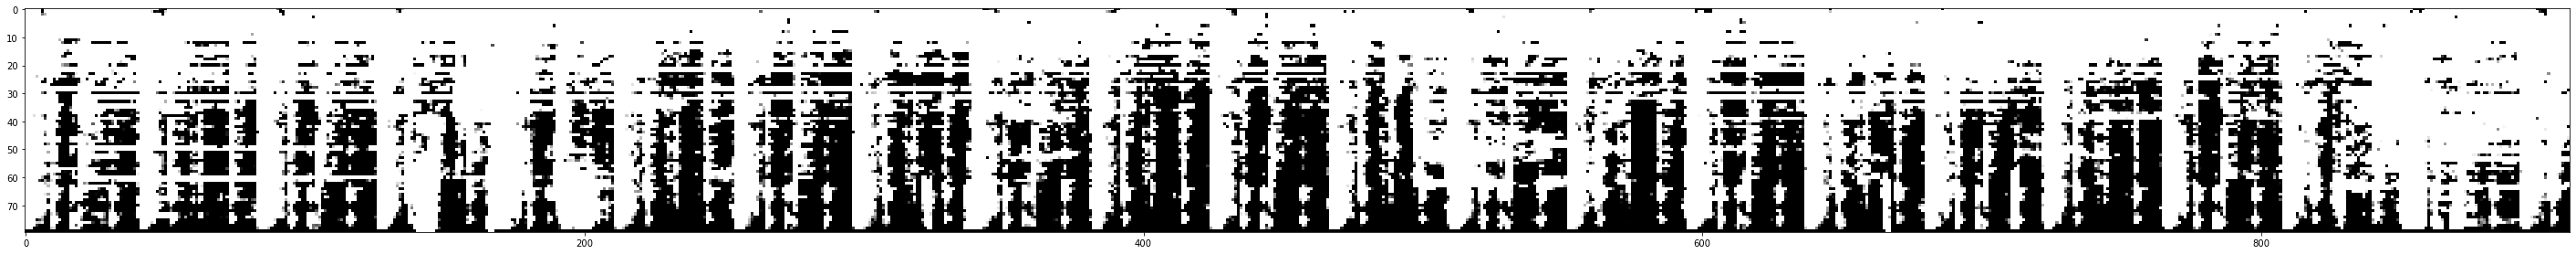

In [8]:
import matplotlib.pyplot as plt
batch = next(iter(train_loader))
spectrograms, labels = batch
grid = torchvision.utils.make_grid(spectrograms, nrow=10)

plt.figure(figsize=(50,100))
plt.imshow(grid.permute(1,2,0))

print('labels:', labels)


In [9]:
class CNN(nn.Module):
    def __init__(self, in_channels=1, num_classes=10):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=64,
            kernel_size=(5, 5),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.pool = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv2 = nn.Conv2d(
            in_channels=64,
            out_channels=64,
            kernel_size=(5, 5),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))

        self.fc1 = nn.Linear(260352, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)

        return x


In [10]:
print(torch.cuda.is_available())

False


In [11]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
in_channel = 1
num_classes = 10
learning_rate = 0.001
batch_size = 1
num_epochs = 5

# Initialize network
model = CNN().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

## Lets train it

In [13]:
from tqdm import tqdm, trange

In [15]:
# Train Network
for epoch in trange(num_epochs):
    for batch_idx, (data, targets) in tqdm(enumerate(train_loader)):
        # forward
        scores = model(data)
        loss = criterion(scores, targets)

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()


  0%|          | 0/5 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:00,  3.91it/s]
2it [00:00,  3.95it/s]
3it [00:00,  3.89it/s]
4it [00:01,  3.67it/s]
5it [00:01,  3.73it/s]
6it [00:01,  3.76it/s]
7it [00:01,  3.68it/s]
8it [00:02,  3.68it/s]
9it [00:02,  3.79it/s]
10it [00:02,  3.82it/s]
11it [00:02,  3.77it/s]
12it [00:03,  3.74it/s]
13it [00:03,  3.80it/s]
14it [00:03,  3.67it/s]
15it [00:04,  3.65it/s]
16it [00:04,  3.76it/s]
17it [00:04,  3.77it/s]
18it [00:04,  3.74it/s]
19it [00:05,  3.76it/s]
20it [00:05,  3.78it/s]
21it [00:05,  3.79it/s]
22it [00:05,  3.86it/s]
23it [00:06,  3.92it/s]
24it [00:06,  3.96it/s]
25it [00:06,  3.97it/s]
26it [00:06,  4.00it/s]
27it [00:07,  3.91it/s]
28it [00:07,  3.79it/s]
29it [00:07,  3.80it/s]
30it [00:07,  3.86it/s]
31it [00:08,  3.90it/s]
32it [00:08,  3.93it/s]
33it [00:08,  3.94it/s]
34it [00:08,  3.96it/s]
35it [00:09,  3.95it/s]
36it [00:09,  3.96it/s]
37it [00:09,  3.96it/s]
38it [00:09,  3.95it/s]
39it [00:10,  3.94it/s]
40it [00:10,  3.

98it [00:26,  3.67it/s]
99it [00:26,  3.66it/s]
100it [00:27,  3.65it/s]
101it [00:27,  3.67it/s]
102it [00:27,  3.65it/s]
103it [00:27,  3.66it/s]
104it [00:28,  3.66it/s]
105it [00:28,  3.67it/s]
106it [00:28,  3.67it/s]
107it [00:29,  3.68it/s]
108it [00:29,  3.69it/s]
109it [00:29,  3.68it/s]
110it [00:29,  3.68it/s]
111it [00:30,  3.69it/s]
112it [00:30,  3.68it/s]
113it [00:30,  3.67it/s]
114it [00:30,  3.69it/s]
115it [00:31,  3.71it/s]
116it [00:31,  3.72it/s]
117it [00:31,  3.71it/s]
118it [00:32,  3.70it/s]
119it [00:32,  3.69it/s]
120it [00:32,  3.70it/s]
121it [00:32,  3.68it/s]
122it [00:33,  3.68it/s]
123it [00:33,  3.70it/s]
124it [00:33,  3.71it/s]
125it [00:33,  3.70it/s]
126it [00:34,  3.68it/s]
127it [00:34,  3.69it/s]
128it [00:34,  3.68it/s]
129it [00:35,  3.66it/s]
130it [00:35,  3.68it/s]
131it [00:35,  3.68it/s]
132it [00:35,  3.67it/s]
133it [00:36,  3.69it/s]
134it [00:36,  3.69it/s]
135it [00:36,  3.66it/s]
136it [00:36,  3.68it/s]
137it [00:37,  3.69it/s]
13

194it [00:52,  3.73it/s]
195it [00:52,  3.74it/s]
196it [00:52,  3.74it/s]
197it [00:53,  3.72it/s]
198it [00:53,  3.72it/s]
 60%|██████    | 3/5 [02:40<01:46, 53.27s/it]
0it [00:00, ?it/s]
1it [00:00,  3.65it/s]
2it [00:00,  3.68it/s]
3it [00:00,  3.68it/s]
4it [00:01,  3.71it/s]
5it [00:01,  3.73it/s]
6it [00:01,  3.74it/s]
7it [00:01,  3.73it/s]
8it [00:02,  3.74it/s]
9it [00:02,  3.73it/s]
10it [00:02,  3.73it/s]
11it [00:02,  3.65it/s]
12it [00:03,  3.63it/s]
13it [00:03,  3.64it/s]
14it [00:03,  3.66it/s]
15it [00:04,  3.68it/s]
16it [00:04,  3.70it/s]
17it [00:04,  3.71it/s]
18it [00:04,  3.72it/s]
19it [00:05,  3.72it/s]
20it [00:05,  3.73it/s]
21it [00:05,  3.72it/s]
22it [00:05,  3.71it/s]
23it [00:06,  3.73it/s]
24it [00:06,  3.70it/s]
25it [00:06,  3.70it/s]
26it [00:07,  3.70it/s]
27it [00:07,  3.67it/s]
28it [00:07,  3.66it/s]
29it [00:07,  3.58it/s]
30it [00:08,  3.61it/s]
31it [00:08,  3.62it/s]
32it [00:08,  3.63it/s]
33it [00:08,  3.66it/s]
34it [00:09,  3.65it/s]
35i

93it [00:26,  3.56it/s]
94it [00:26,  3.58it/s]
95it [00:26,  3.58it/s]
96it [00:27,  3.59it/s]
97it [00:27,  3.58it/s]
98it [00:27,  3.59it/s]
99it [00:27,  3.59it/s]
100it [00:28,  3.58it/s]
101it [00:28,  3.59it/s]
102it [00:28,  3.59it/s]
103it [00:28,  3.59it/s]
104it [00:29,  3.59it/s]
105it [00:29,  3.58it/s]
106it [00:29,  3.58it/s]
107it [00:30,  3.56it/s]
108it [00:30,  3.57it/s]
109it [00:30,  3.56it/s]
110it [00:30,  3.59it/s]
111it [00:31,  3.58it/s]
112it [00:31,  3.58it/s]
113it [00:31,  3.59it/s]
114it [00:32,  3.60it/s]
115it [00:32,  3.59it/s]
116it [00:32,  3.61it/s]
117it [00:32,  3.61it/s]
118it [00:33,  3.60it/s]
119it [00:33,  3.60it/s]
120it [00:33,  3.61it/s]
121it [00:34,  3.62it/s]
122it [00:34,  3.61it/s]
123it [00:34,  3.60it/s]
124it [00:34,  3.59it/s]
125it [00:35,  3.60it/s]
126it [00:35,  3.59it/s]
127it [00:35,  3.58it/s]
128it [00:35,  3.58it/s]
129it [00:36,  3.58it/s]
130it [00:36,  3.56it/s]
131it [00:36,  3.56it/s]
132it [00:37,  3.58it/s]
133it [

In [ ]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

        print(
            f"Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}"
        )

    model.train()

In [ ]:
test_dataset.X

In [ ]:
print("Checking accuracy on training data")
check_accuracy(train_loader, model)

print("Checking accuracy on test data")
check_accuracy(test_loader, model)